## Analysis for my implementation of early visual system
Mitchell B. Slapik, Harel Z. Shouval; Simulated Complex Cells Contribute to Object Recognition Through Representational Untangling. 
Neural Comput 2026; 38 (2): 145-164. doi: https://doi.org/10.1162/NECO.a.1480

Sakin Kirti

I'll use the CIFAR-10 dataset, so we'll load one batch just to test it out.

In [1]:
import numpy as np
import cv2
import pandas as pd
import pickle

import matplotlib.pyplot as plt

import torch
from model_slapik import VVS

from tqdm import tqdm

## Load data

In [2]:
# read from cifar-10
with open("/Users/sakinkirti/Programming/ucla/dipoppa-lab/01_data/cifar-10-batches-py/data_batch_1", 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')

dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

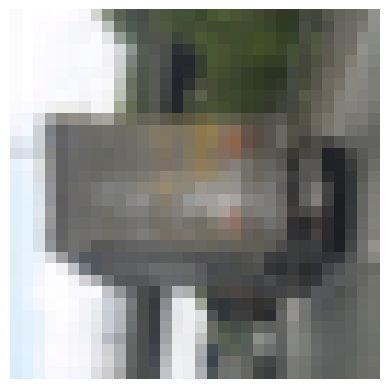

In [3]:
# let's just show one image to make sure we have it properly
plt.imshow(dict[b"data"][472].reshape((3, 32, 32)).T)
plt.axis("off")
plt.show()

Tbh, i have no idea what i'm looking at here - but that's okay. it doesnt matter what i think... Let's convert these to grayscale

In [4]:
data = torch.stack(
    [torch.Tensor(cv2.rotate(cv2.cvtColor(d.reshape((3, 32, 32)).T, cv2.COLOR_BGR2GRAY), cv2.ROTATE_90_CLOCKWISE).reshape((1, 32, 32))) for d in dict[b"data"]]
)
data.shape

torch.Size([10000, 1, 32, 32])

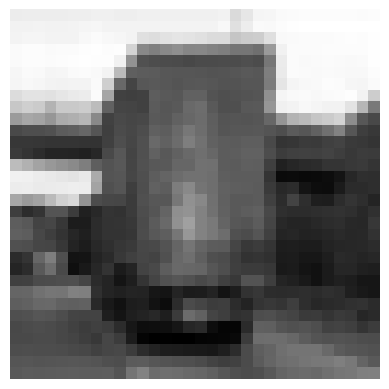

In [5]:
# let's just make sure our data still looks right
plt.imshow(*data[472], cmap="gray")
plt.axis("off")
plt.show()

In [6]:
# let's normalize the data
data = (data - torch.mean(data)) / torch.std(data)
data.shape

torch.Size([10000, 1, 32, 32])

In [7]:
B, C, H, W = data[:64].shape
model = VVS(input_shape=(B, C, H, W)) # (batch, channel, height, width)
(ret, lgn, sim, com) = model(data[:64], "all") # send 64 samples

In [10]:
com.shape

torch.Size([64, 8, 32, 32])

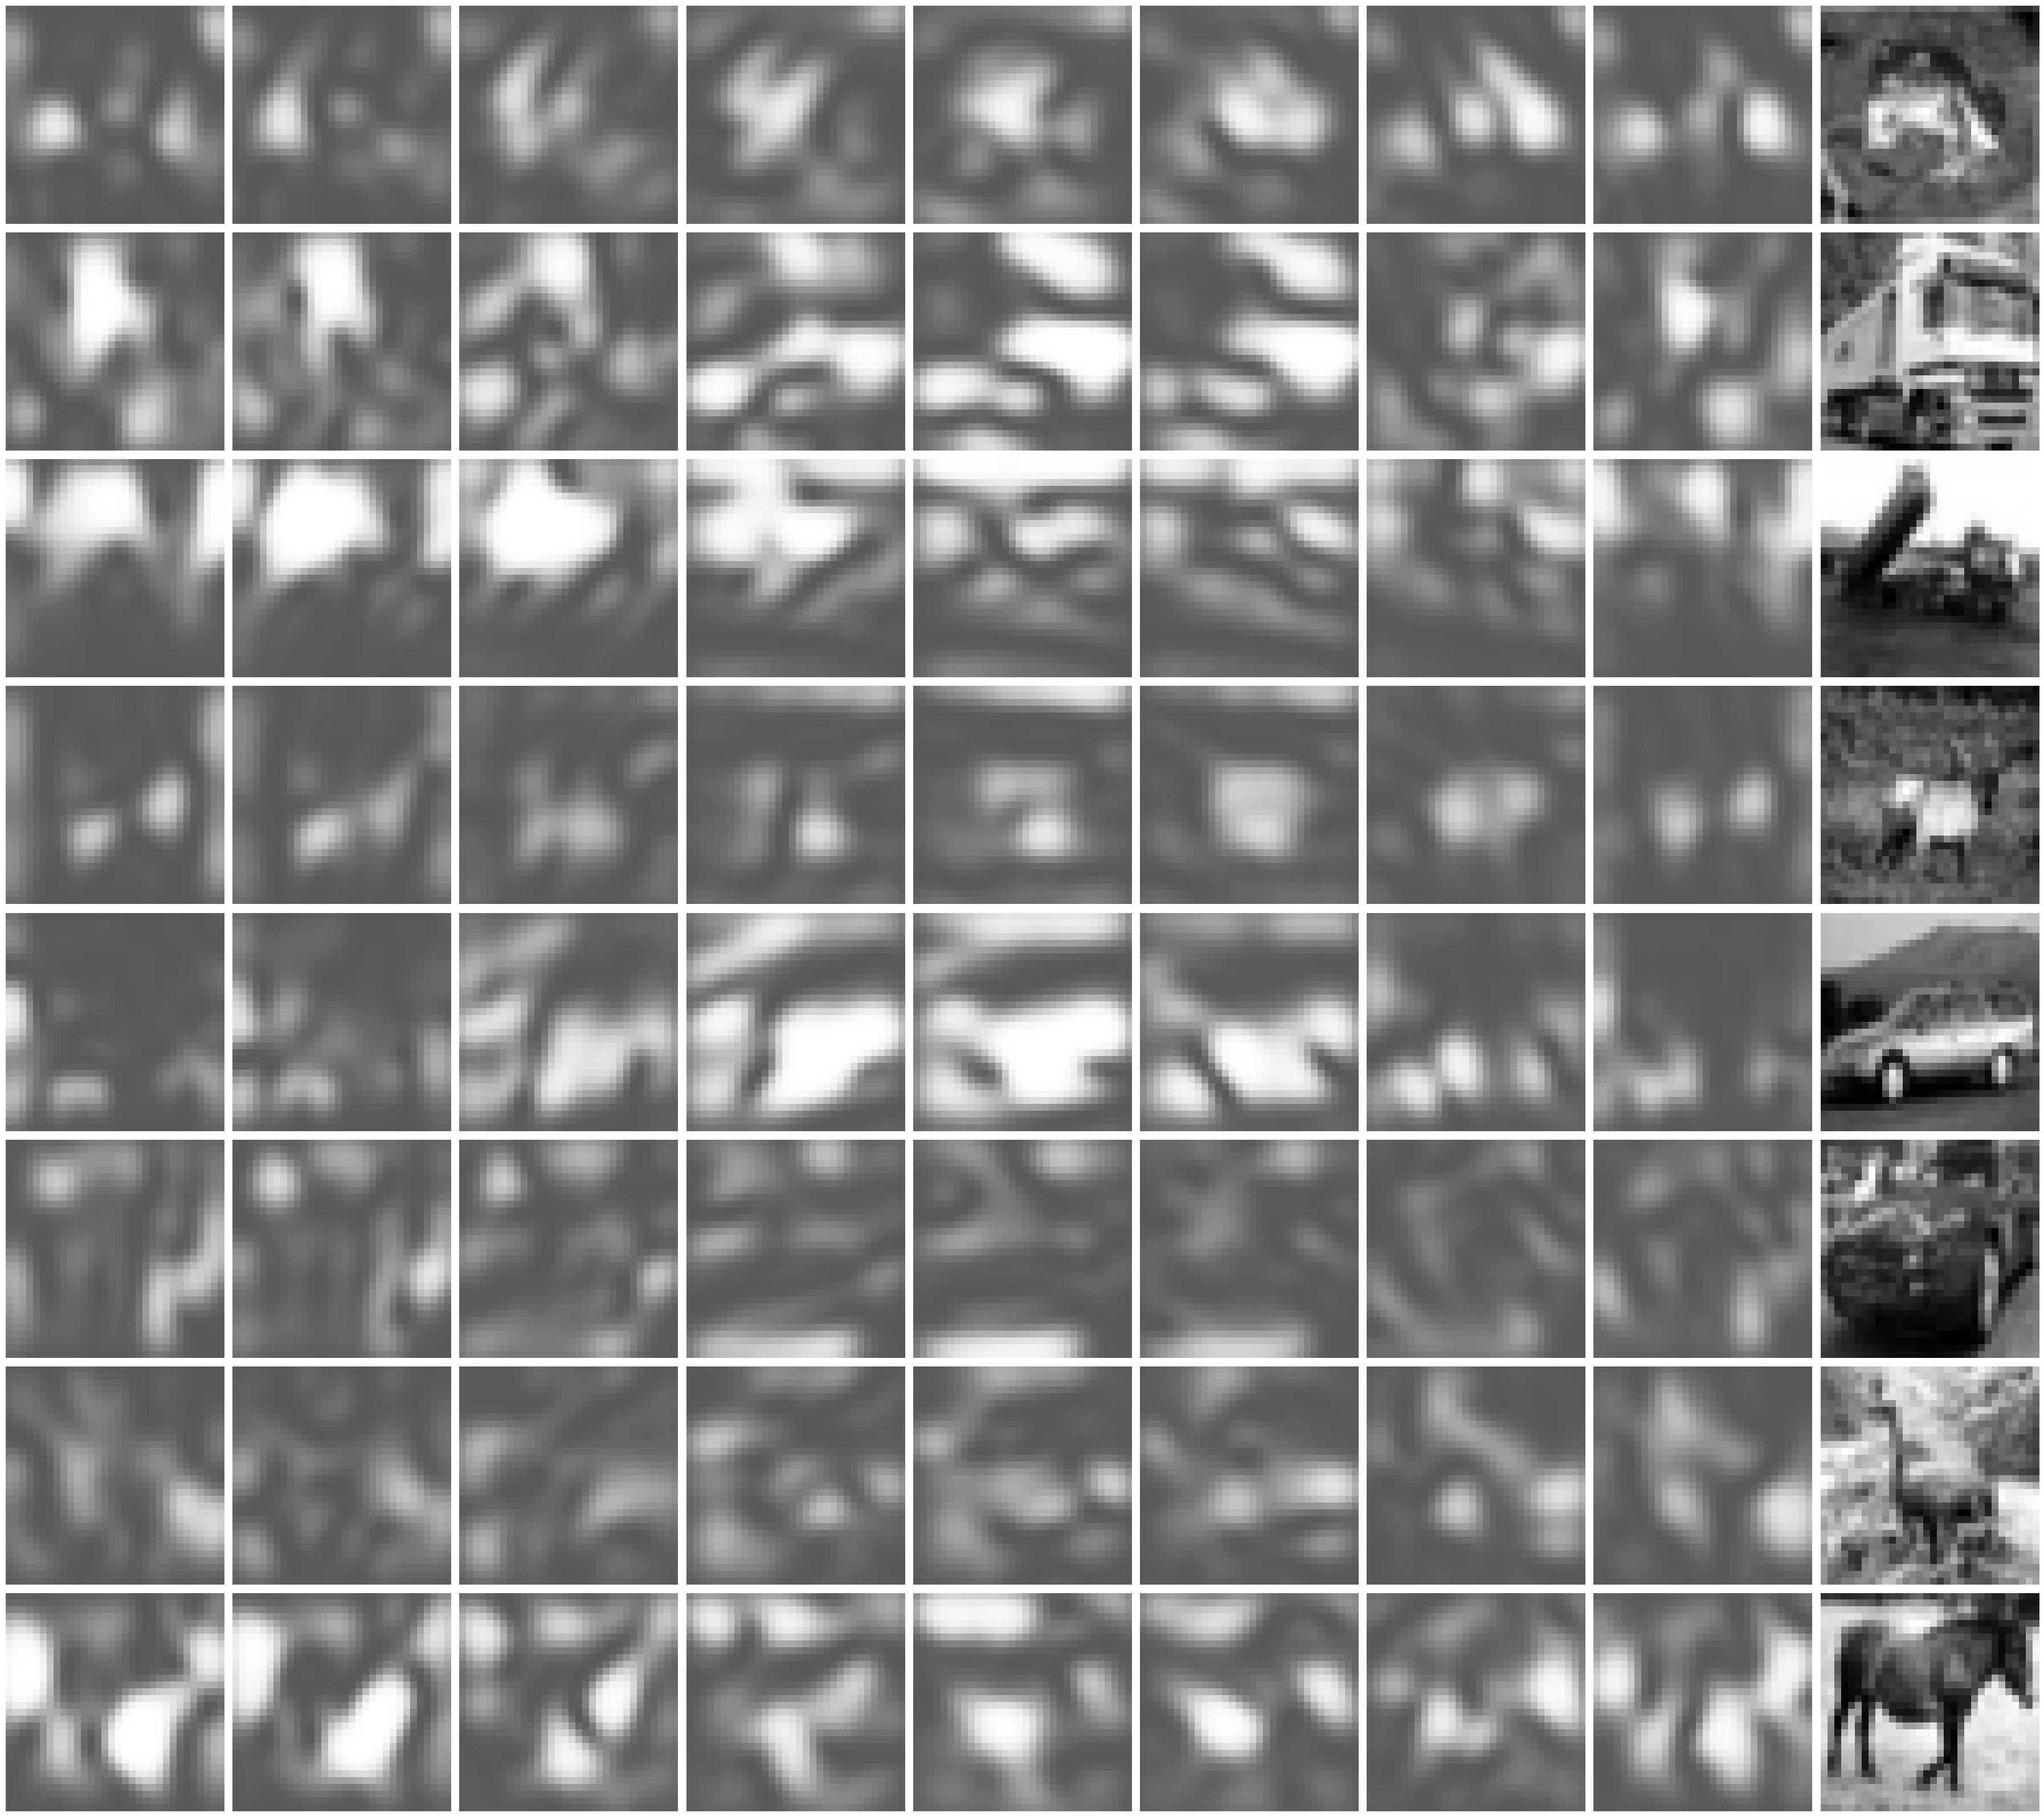

In [11]:
# let's plot the outputs of the complex cells (just 8 of them)
fig, ax = plt.subplots(8, 9, figsize=(36, 32))

i = 0
while i < 8:
    a = 0
    while a < 9:
        if a == 8:
            ax[i][a].imshow(*data[:64][i], cmap="gray")
            ax[i][a].axis("off")
        else:
            ax[i][a].imshow(com[i][a], cmap="gray", vmin=0, vmax=1)
            ax[i][a].axis("off")
        a += 1
    i += 1

fig.set_tight_layout(True)
plt.show()

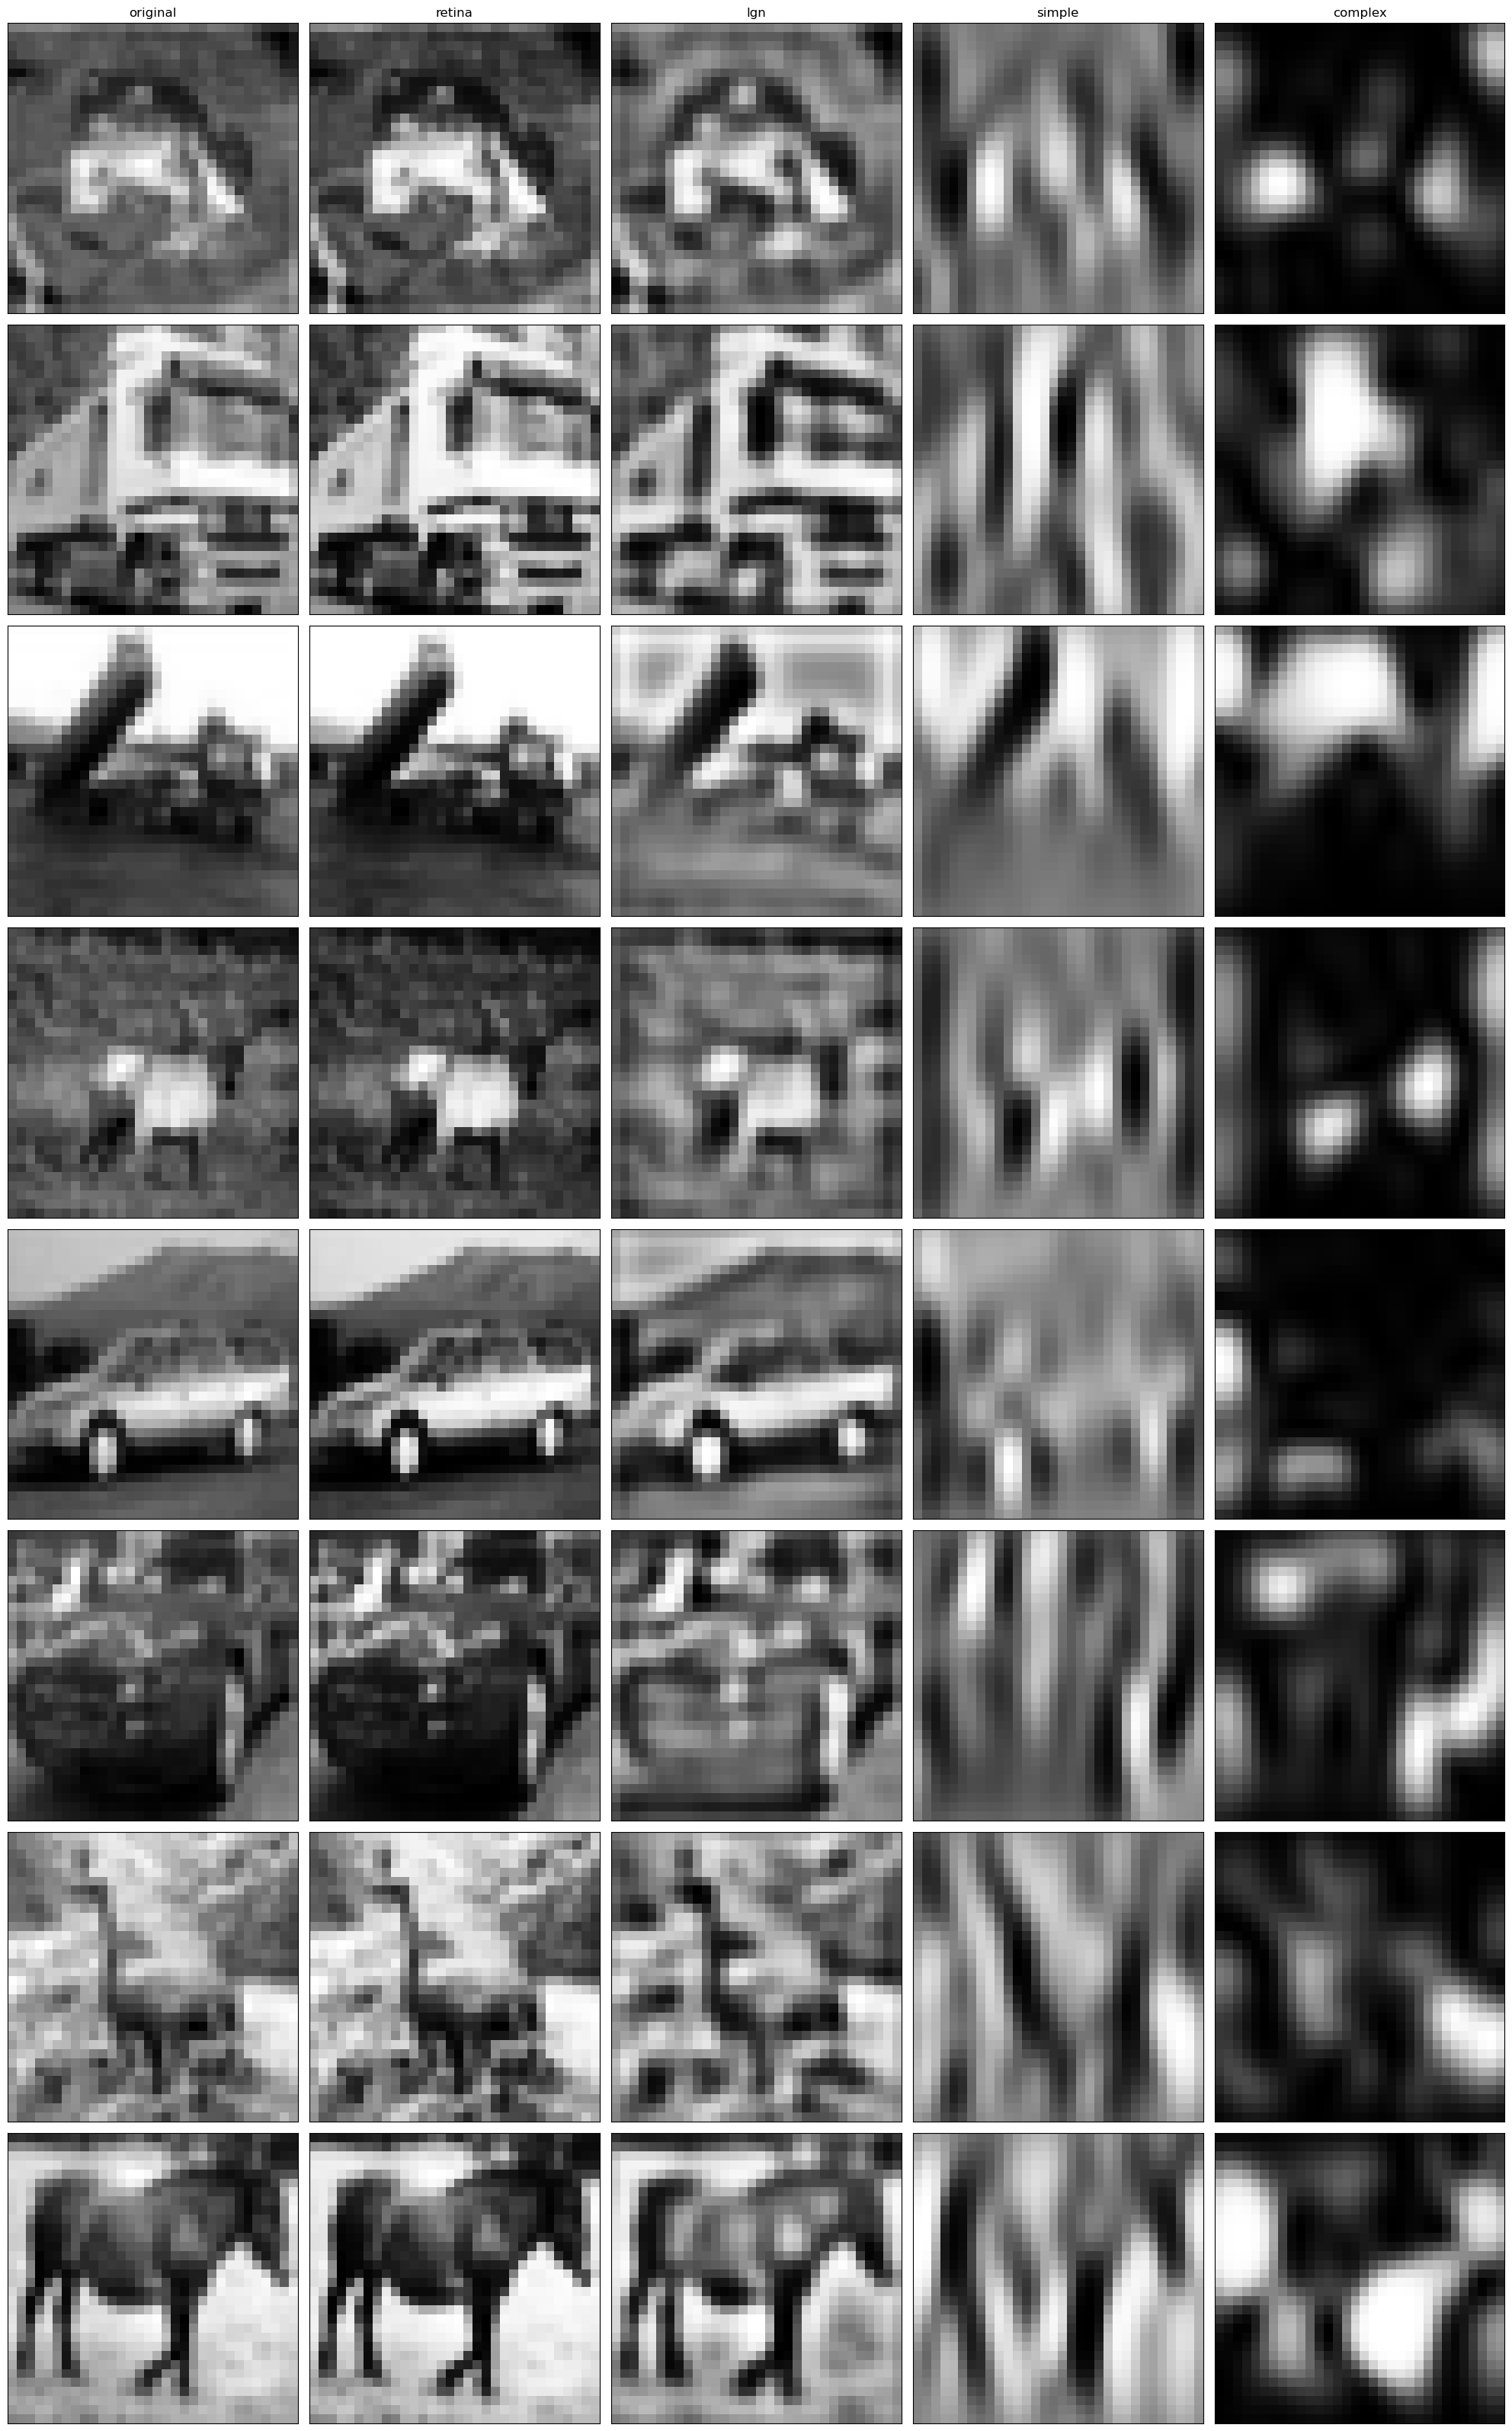

In [13]:
# hmm seems like we're messing up somewhere. let's plot the in-betweens
fig, ax = plt.subplots(8, 5, figsize=(20, 32))

i = 0
while i < 8:
    ax[i][0].imshow(*data[:64][i], cmap="gray")
    ax[i][1].imshow(*ret[i], cmap="gray")
    ax[i][2].imshow(*lgn[i], cmap="gray")
    ax[i][3].imshow(sim[i][0], cmap="gray")
    ax[i][4].imshow(com[i][0], cmap="gray")
    
    # let's just turn of the ticks
    for a in ax[i]:
        a.set_xticks([])
        a.set_yticks([])
    i += 1

ax[0][0].set_title("original")
ax[0][1].set_title("retina")
ax[0][2].set_title("lgn")
ax[0][3].set_title("simple")
ax[0][4].set_title("complex")

fig.set_tight_layout(True)
plt.show()

## Let's run the data on everything

In [14]:
# okay, since this seems to work, let's run this on all of our data
batch_size = 500

# we can alter the number of output neurons, K, by altering n_theta (or the shape of the image we give to the network)
# n_theta changes the ratio N:K
n_theta = 8

# define our model
B, C, H, W = data[:batch_size].shape
model = VVS(input_shape=(B, C, H, W), n_simple_cell_types=n_theta) # (batch, channel, height, width)

In [15]:
ret_out = []
lgn_out = []
sim_out = []
com_out = []

for b in tqdm(range(0, data.shape[0], batch_size)):

    # load a single batch
    try:
        batch = data[b:b+batch_size]
    except:
        break # just break if there's an array length error

    # get our representations
    (ret, lgn, sim, com) = model(batch, "all") # send samples
    ret_out.append(ret)
    lgn_out.append(lgn)
    sim_out.append(sim)
    com_out.append(com)

100%|██████████| 20/20 [00:03<00:00,  5.46it/s]


In [16]:
ret_out = np.array(ret_out)
lgn_out = np.array(lgn_out)
sim_out = np.array(sim_out)
com_out = np.array(com_out)

In [17]:
ret_out = ret_out.reshape(ret_out.shape[0]*ret_out.shape[1], ret_out.shape[2], ret_out.shape[3], ret_out.shape[4])
lgn_out = lgn_out.reshape(lgn_out.shape[0]*lgn_out.shape[1], lgn_out.shape[2], lgn_out.shape[3], lgn_out.shape[4])
sim_out = sim_out.reshape(sim_out.shape[0]*sim_out.shape[1], sim_out.shape[2], sim_out.shape[3], sim_out.shape[4])
com_out = com_out.reshape(com_out.shape[0]*com_out.shape[1], com_out.shape[2], com_out.shape[3], com_out.shape[4])

In [18]:
# rearrange into retina, lgn, and v1 representations
v1_out = np.hstack([sim_out, com_out])
v1_out.shape # (num_images, sim+com, H, W)

(10000, 16, 32, 32)

In [19]:
ret_out = ret_out.reshape((ret_out.shape[0], -1))
lgn_out = lgn_out.reshape((lgn_out.shape[0], -1))
sim_out = sim_out.reshape((sim_out.shape[0], -1))
com_out = com_out.reshape((com_out.shape[0], -1))
v1_out = v1_out.reshape((v1_out.shape[0], -1))
print(f"retina shape: {ret_out.shape}, lgn shape: {lgn_out.shape}, v1 shape: {v1_out.shape}")

retina shape: (10000, 1024), lgn shape: (10000, 1024), v1 shape: (10000, 16384)


In [20]:
# let's run an LDA with these data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# on retinal data
lda_ret = LDA()
lda_ret.fit(ret_out, dict[b"labels"])
ret_preds = lda_ret.predict(ret_out)
print("completed retina")

# on lgn data
lda_lgn = LDA()
lda_lgn.fit(lgn_out, dict[b"labels"])
lgn_preds = lda_lgn.predict(lgn_out)
print("completed lgn")

# on simple data
lda_sim = LDA()
lda_sim.fit(sim_out, dict[b"labels"])
sim_preds = lda_sim.predict(sim_out)
print("completed simple")

# on complex data
lda_com = LDA()
lda_com.fit(com_out, dict[b"labels"])
com_preds = lda_com.predict(com_out)
print("completed complex")

# on v1 data
lda_v1 = LDA()
lda_v1.fit(v1_out, dict[b"labels"])
v1_preds = lda_v1.predict(v1_out)
print("completed v1")

completed retina
completed lgn
completed simple
completed complex
completed v1


In [21]:
from sklearn.metrics import accuracy_score

# compute the accuracy of each
ret_acc = accuracy_score(dict[b"labels"], ret_preds)
lgn_acc = accuracy_score(dict[b"labels"], lgn_preds)
sim_acc = accuracy_score(dict[b"labels"], sim_preds)
com_acc = accuracy_score(dict[b"labels"], com_preds)
v1_acc = accuracy_score(dict[b"labels"], v1_preds)

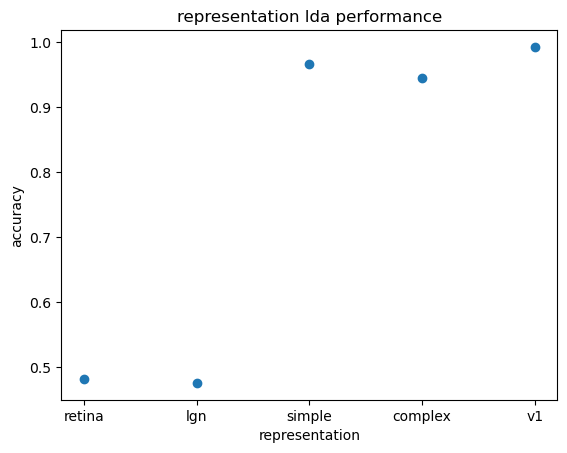

In [22]:
# okay, now let's just plot our results
plt.scatter(np.arange(5), [ret_acc, lgn_acc, sim_acc, com_acc, v1_acc])
plt.xticks(np.arange(5), ["retina", "lgn", "simple", "complex", "v1"])
plt.title("representation lda performance")
plt.ylabel("accuracy")
plt.xlabel("representation")
plt.show()

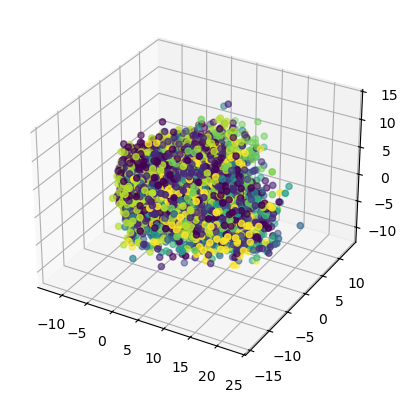

In [32]:
# if these are really that easily linearly decodable, then we should be able to see that with a plot. let me do a quick pca of this data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=50)
pca.fit(com_out)

ret_pca = pca.transform(com_out)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(ret_pca[:, 0], ret_pca[:, 1], ret_pca[:, 2], c=dict[b"labels"])
plt.show()